In [112]:
import torch
from torchvision.transforms import transforms
from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
import requests

In [113]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    return np.array(img)

Ok, Let's use a pre-trained network as a feature extractor. We'll do this by slicing the last layers off Alexnet.

In [114]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.eval()

Using cache found in /home/michael/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [115]:
# Replace the final classifier projection with nothing
alexnet.classifier[-1] = torch.nn.Sequential()

In [116]:
# It's gone now
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [117]:
# Lets get some images
url = "https://static.wikia.nocookie.net/waldo/images/9/9d/Character.Waldo.jpg/revision/latest/top-crop/width/200/height/150?cb=20071001045624"
wally = read_image_from_url(url)

url = "https://static.wikia.nocookie.net/waldo/images/4/45/Character.Odlaw.jpg/revision/latest/top-crop/width/200/height/150?cb=20071001053010"
odlaw = read_image_from_url(url)

url = "https://static.wikia.nocookie.net/waldo/images/3/3e/Character.Wenda.jpg/revision/latest/top-crop/width/200/height/150?cb=20071001044014"
wenda = read_image_from_url(url)

url = "https://static.wikia.nocookie.net/waldo/images/9/9d/Character.Waldo.jpg/revision/latest/scale-to-width-down/150?cb=20071001045624"
test_image = read_image_from_url(url)

In [118]:
# Preprocessing needed for alexnet
preprocess = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

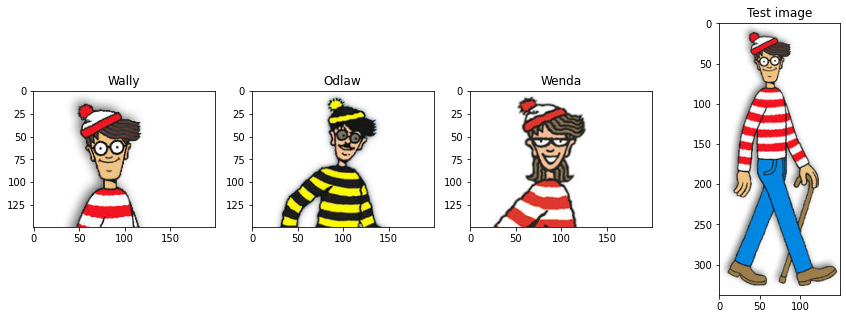

In [119]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(wally)
plt.title('Wally')
plt.subplot(1,4,2)
plt.imshow(odlaw)
plt.title('Odlaw')
plt.subplot(1,4,3)
plt.imshow(wenda)
plt.title('Wenda')
plt.subplot(1,4,4)
plt.imshow(test_image)
plt.title('Test image')
plt.show()

In [120]:
# Let's extract features using alexnet
img_batch = preprocess(wally).unsqueeze(0)
feature_wally = alexnet(img_batch)
img_batch = preprocess(odlaw).unsqueeze(0)
feature_odlaw = alexnet(img_batch)
img_batch = preprocess(wenda).unsqueeze(0)
feature_wenda = alexnet(img_batch)
img_batch = preprocess(test_image).unsqueeze(0)
feature_test = alexnet(img_batch)

What dimension are the features? Look above to see?

In [121]:
feature_wally.shape

torch.Size([1, 4096])

Ok, let's use these features as descriptors and see which one our test image is most similar to

In [122]:
print('Wally distance: ',torch.sum((feature_wally-feature_test)**2).item())
print('Wenda distance: ',torch.sum((feature_wenda-feature_test)**2).item())
print('Odlaw distance: ',torch.sum((feature_odlaw-feature_test)**2).item())

Wally distance:  6164.76220703125
Wenda distance:  6361.875
Odlaw distance:  9198.3369140625


Euclidean distances are weird in high dims, so more common to use cosine similarity

In [123]:
print('Wally similarity: ',torch.nn.CosineSimilarity()(feature_wally,feature_test).item())
print('Wenda similarity: ',torch.nn.CosineSimilarity()(feature_wenda,feature_test).item())
print('Odlaw similarity: ',torch.nn.CosineSimilarity()(feature_odlaw,feature_test).item())

Wally similarity:  0.4775424003601074
Wenda similarity:  0.424821674823761
Odlaw similarity:  0.4041283428668976


That's cool. Our test picture of Wally is closest to the image of his face! Let's make it harder and see if we can find wally in a more challenging image.

In [124]:
url = 'https://static.boredpanda.com/blog/wp-content/uploads/2020/03/where-is-waldo-coronavirus-edition-book-5-5e73257690fa2__700.jpg'
base_image = read_image_from_url(url)

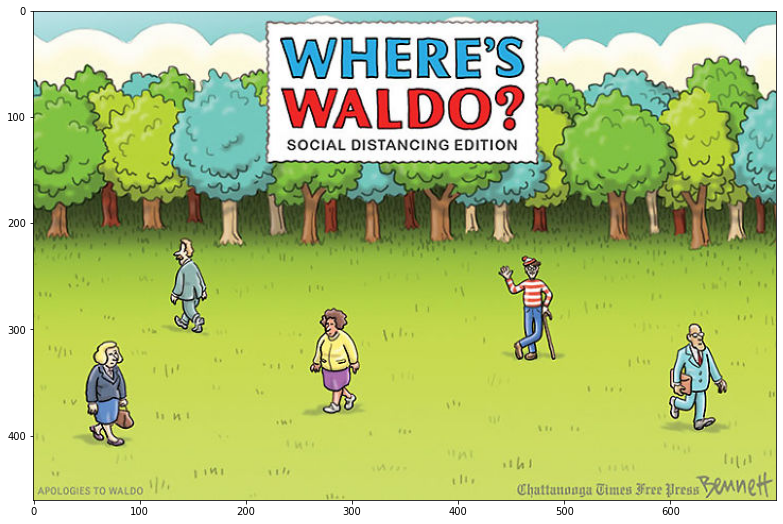

In [125]:
plt.figure(figsize=(15,9))
plt.imshow(base_image)
plt.show()

I am going to divide this image into pn x pn patches, extract features in each, and compute the similarity between this and Wally's face feature above. I'll store this in a heatmap to overlay on the image above.

In [126]:
pn = 8
dists = []
for i in np.linspace(0,base_image.shape[0],pn+1,dtype=int)[:-1]:
    for j in np.linspace(0,base_image.shape[1],pn+1,dtype=int)[:-1]:
        w = int(base_image.shape[0]/pn)
        h = int(base_image.shape[1]/pn)
        
        patch = base_image[i:i+w,j:j+h,:]
        
        img_batch = preprocess(patch).unsqueeze(0)
        patch_feature = alexnet(img_batch)

        distance = torch.nn.CosineSimilarity()(patch_feature,feature_wally).item()
        
        dists.append(distance)

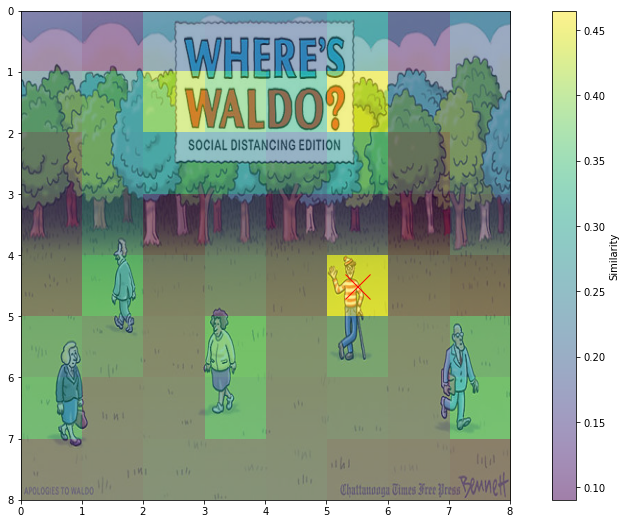

In [127]:
plt.figure(figsize=(15,9))
plt.imshow(base_image,extent=[0,pn,pn,0])
plt.imshow(np.array(dists).reshape(pn,pn),alpha=0.5,extent=[0,pn,pn,0])
idx = np.argmax(np.array(dists).reshape(pn,pn))
plt.plot(idx%pn+0.5,idx//pn+0.5,'rx',markersize=25)
plt.colorbar(label='Similarity')
plt.show()

Nice, we found Wally! This quick similarity measure between features shows us a couple things. 

1. The network has learned to encode our image into a feature vector that retains useful information about images. 
2. This feature vector appears to have some invariances built in.
3. Even though the network wasn't trained for this (Wally isn't in imagenet classes), the representation is useful. 

We could re-use this, eg. by training a logistic regression classifier like we did in week 8, to get a powerfull recognition model. Or we could fine-tune the existing model on a new dataset, to improve the entire model. This reduces some of the data requirements we may have if training from scratch.

### Activity:

* Try change the patch number/size and see how this affects the distance measure.
* Try find a harder image to test with online - it probably won't work. 

Next week we will look at models that do detection by region proposal, a much faster approach than the search we just did. 